# True Reach Estimator

***

We are looking to build an estimator around instagram users true reach and impressions. This data is accessible through the business api but in Q1 2018 Instagram blocked influencer marketing teams from this endpoint. We are able to collect a sample of this data to see if there working correlations between currently public data and true reach/impressions. 

Data: the CSV we have contains one year worth of data from 5,000 influencer level Instagram users. 

## The goal: 
Given the public data points create an accurate estimate of each posts reach and impressions. The ideal would be as accurate as possible, but a 10% range will work for the business. 

# Trial - Determine Outlier Data by Ratio

After many trials we have learned that while our 3 variables are appropriate for a regression we were still not able to accurately predict the dependent variable. 

In this trial we focused on exploring the data looking to find the most appropriate method to remove outlier data. Instagram's algorithm produces larger variance in individual results. These results had a detremental effect on any prediction results. Eliminating outliers of a single large or small variable has a negative effect on our model as our users vary greatly. A user might have 10,000 comments, which could seem like an outlier, until you see they also have 1mil followers. What is instead a non-normal event is finding a user with 1mil followers with only 1 comment. 

We determined that issues arose when the ratios of certain variables violated normality. As such, we chose to eliminate the upper and lower 10% of the offending ratios to help fit the model. We did this symetrically and uniformally across the three variables to maintain a set that could still have some unbiased relationship. 

For this group we have only included users with followers from 1 to 10,000 to better match the reactions to posts. 

Process:

- work with users that have  0-10k followers.
- Change the confidence interval to 10% or 90%.

---


- Import the data
- Split the data into a test and training set
- Set conditions on the training data to eliminate outliers
- Create a regression model on our variables to determine the effectiveness of the data so far 
- Use the regression model to check for accuracy in the perdiction across the dataset
- Summarize our findings and suggest next steps if unsucessful

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')

Pull in the CSV file

In [2]:
df = pd.read_csv('trial_1_2.csv')

Drop columns that are unneeded.

In [3]:
df2 = df.drop(['Unnamed: 0'], axis=1)

**First Data Clean**

Anyone with very little reach will skew the data. It's probably a bot. Lets remove all rows where the reach is less than 300.

In [4]:
df2 = df2.loc[(df2['reach']>1)] #& (df2['reach']<200000)
len(df2)

727924

### Set a range for follower count
Next we decided to remove rows that have less than 1000 followers. This not only helps eliminate outliers but in the data collection there were many rows with exactly zero followers yet high numbers in reach. This data clearly is not correct or not in the style we are looking for. 

In [5]:
df2 = df2.loc[(df2['followers']>1000) & (df2['followers']<10000)]
len(df2)

164693

In [6]:
df2 = df2.loc[(df2['followers']>1)]

Setting comments to greater than zero to avoid zero division errors

In [7]:
df2 = df2.loc[(df2['comments']>=1)] # & (df2['comments']<=2000)
len(df2)

155943

Remove rows with less than 100 likes to eliminate outliers.

In [8]:
df2 = df2.loc[(df2['likes']>=1)]
len(df2)

155943

Remove wierd situations where there are more comments or likes than reach.

In [9]:
df2 = df2.loc[(df2.likes<df2.reach)]
df2 = df2.loc[(df2.comments<df2.reach)]
len(df2)

153462

## Split the data sets into two - a test and a training data set: 

In [10]:
from sklearn.model_selection import train_test_split
df2, test = train_test_split(df2, test_size=0.2)

---

# Eliminate the data with *RATIOS* outside of the norm. 

## Step 1 - Add ratio colums onto the data frame

In [11]:
df2['reach_/_followers'] = df2['reach']/df2['followers']

In [12]:
df2['reach_/_likes'] = df2['reach']/df2['likes']

In [13]:
df2['reach_/_comments'] = df2['reach']/df2['comments']

#### Look at the distribution of those ratio without manipulation

(-0.0004, 1000)

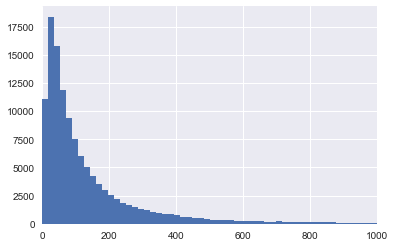

In [14]:
plt.hist(df2['reach_/_comments'], bins=1000)
plt.xlim(-.0004,1000)

(-0.03, 3)

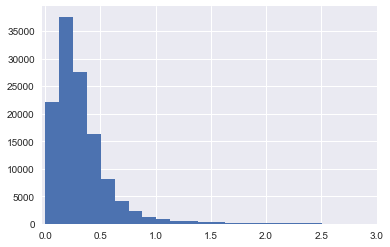

In [15]:
plt.hist(df2['reach_/_followers'], bins=1000)
plt.xlim(-.03,3)

(-0.003, 30)

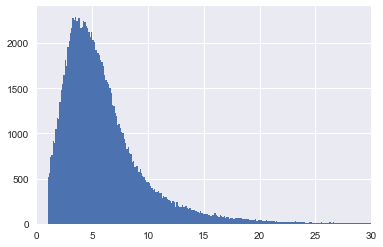

In [16]:
plt.hist(df2['reach_/_likes'], bins=1000)
plt.xlim(-.003, 30)

## Step 2 - Set confidence intervals for each ration

 *Just checking what some filters would look like without finding a confidence interval.* 

In [17]:
len(df2[(df2['reach_/_followers'] < df2['reach_/_followers'].quantile(.05))])

6133

In [18]:
len(df2[(df2['reach_/_followers'] > df2['reach_/_followers'].quantile(.95))])

6139

In [19]:
len(df2[(df2['reach_/_likes'] > df2['reach_/_likes'].quantile(.95))])

6139

In [20]:
len(df2[(df2['reach_/_likes'] < df2['reach_/_likes'].quantile(.05))])

6139

In [21]:
len(df2[(df2['reach_/_comments'] < df2['reach_/_comments'].quantile(.05))])

6139

In [22]:
len(df2[(df2['reach_/_comments'] > df2['reach_/_comments'].quantile(.95))])

6139

In [23]:
df2= df2.loc[(df2['reach_/_followers'] > df2['reach_/_followers'].quantile(.1))]
df2= df2.loc[(df2['reach_/_likes'] > df2['reach_/_likes'].quantile(.1))]
df2= df2.loc[(df2['reach_/_comments'] > df2['reach_/_comments'].quantile(.1))]

df2= df2.loc[(df2['reach_/_followers'] < df2['reach_/_followers'].quantile(.9))]
df2= df2.loc[(df2['reach_/_likes'] < df2['reach_/_likes'].quantile(.9))]
df2= df2.loc[(df2['reach_/_comments'] < df2['reach_/_comments'].quantile(.9))]

In [24]:
len(df2)

65239

Now, what does our data look like? 

(18, 350)

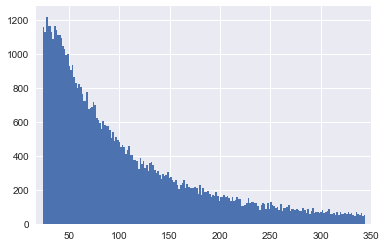

In [25]:
plt.hist(df2['reach_/_comments'], bins=200)
plt.xlim(18, 350)

(2, 12)

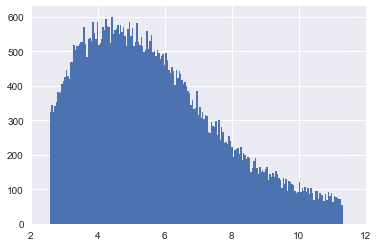

In [26]:
plt.hist(df2['reach_/_likes'], bins=200)
plt.xlim(2, 12)

(0.082, 0.7)

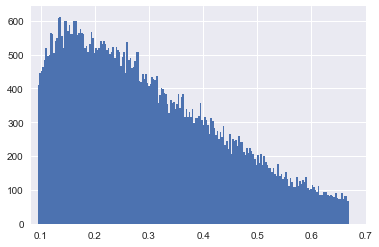

In [27]:
plt.hist(df2['reach_/_followers'], bins=200)
plt.xlim(.082, .7)

# Fit the model

In [28]:
lr_model = ols(formula='reach~followers + likes + comments', data=df2).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  reach   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                 6.492e+04
Date:                Fri, 08 Mar 2019   Prob (F-statistic):               0.00
Time:                        11:53:13   Log-Likelihood:            -4.9126e+05
No. Observations:               65239   AIC:                         9.825e+05
Df Residuals:                   65235   BIC:                         9.826e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     38.0450      3.609     10.542      0.000      30.972      45.118
followers      0.0908      0.001    110.150      0.000       0.089       0.092
likes          2.8836      0.014    210.198      0.000       2.857       2.911
comments       5.9868      0.132     45.210      0.000       5.727       6.246
==============================================================================
Omnibus:                    17281.235   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            76734.823
Skew:                           1.235   Prob(JB):                         0.00
Kurtosis:                       7.704   Cond. No.                     1.06e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Scatterplots 
- Next we look at scatter plots of our data to further look for outliers and the correlation of our independent variable to our dependent variable. 

Text(0.5, 1.0, 'Followers Correlation plot')

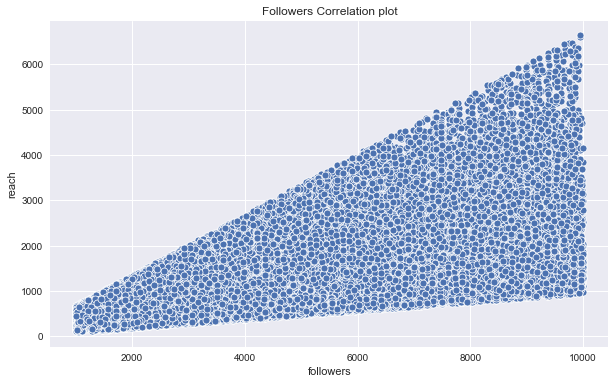

In [29]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df2.followers, y=df2.reach)
plt.xlabel('followers')
plt.ylabel('reach')
plt.title("Followers Correlation plot")

Text(0.5, 1.0, 'Likes Correlation plot')

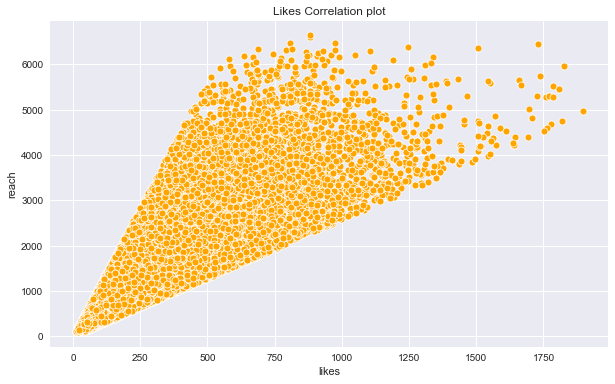

In [30]:
plt.figure(figsize=(10,6))
sns.scatterplot(y=df2.reach, x=df2.likes, color='orange' )
plt.xlabel('likes')
plt.ylabel('reach')
plt.title("Likes Correlation plot")

Text(0.5, 1.0, ' Comments Correlation plot')

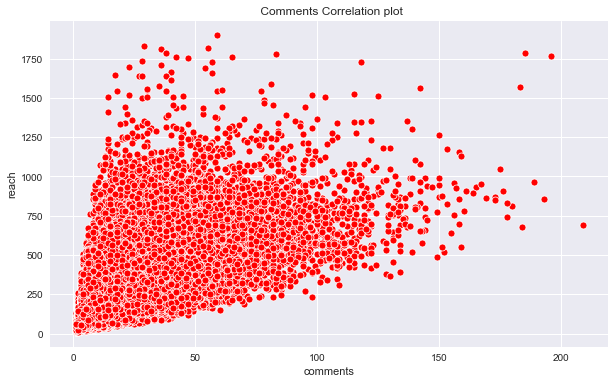

In [31]:
plt.figure(figsize=(10,6))
sns.scatterplot(y=df2.likes, x=df2.comments, color='red')
plt.xlabel('comments')
plt.ylabel('reach')
plt.title(" Comments Correlation plot")

Further we used Statsmodels to create an OLS model. This allows us to see all the import statistics and values associated with the three variables together. 

In [32]:
lr_model = ols(formula='reach~followers+likes+comments', data=df2).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  reach   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                 6.492e+04
Date:                Fri, 08 Mar 2019   Prob (F-statistic):               0.00
Time:                        11:53:16   Log-Likelihood:            -4.9126e+05
No. Observations:               65239   AIC:                         9.825e+05
Df Residuals:                   65235   BIC:                         9.826e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     38.0450      3.609     10.542      0.000      30.972      45.118
followers      0.0908      0.001    110.150      0.000       0.089       0.092
likes          2.8836      0.014    210.198      0.000       2.857       2.911
comments       5.9868      0.132     45.210      0.000       5.727       6.246
==============================================================================
Omnibus:                    17281.235   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            76734.823
Skew:                           1.235   Prob(JB):                         0.00
Kurtosis:                       7.704   Cond. No.                     1.06e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Test the Model Against Training Data

Create a quick function to run the coefficients from the three variables. 

In [33]:
df2['test_reach'] = round(lr_model.predict(df2),1)

In [34]:
df2['reach_diff'] = round(df2['reach'] - df2['test_reach'],1)

In [35]:
df2.head()

,followers,published,likes,comments,impressions,reach,reach_/_followers,reach_/_likes,reach_/_comments,test_reach,reach_diff
241225,6249,2018-03-23T15:42:17.000+00:00,434,34,5312,3968,0.634982,9.142857,116.705882,2060.5,1907.5
62270,2329,2018-04-25T21:46:25.000+00:00,110,16,760,619,0.265779,5.627273,38.687500,662.5,-43.5
192682,6246,2018-02-17T19:19:48.000+00:00,563,122,4963,3578,0.572847,6.355240,29.327869,2959.1,618.9
685587,1232,2018-05-02T16:18:37.000+00:00,182,16,1014,710,0.576299,3.901099,44.375000,770.5,-60.5
480162,2941,2018-03-14T00:50:33.000+00:00,67,2,484,425,0.144509,6.343284,212.500000,510.3,-85.3


In [36]:
df2['diff_ratio'] = round((df2.reach_diff / df2.reach)*100, 1)

Text(0.5, 1.0, 'Accuracy of Regression Model Prediction')

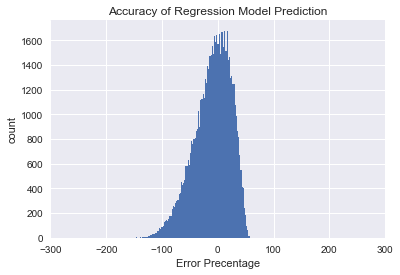

In [37]:
x = plt.hist(df2.diff_ratio, bins = 100)
plt.xlim(-300, 300)
plt.xlabel('Error Precentage')
plt.ylabel('count')
plt.title('Accuracy of Regression Model Prediction')

In [38]:
mean_squared_error(df2.reach, df2.test_reach)**.5

450.8573123441689

## Test the Model Against Uncleaned Test Data

Add Test Reach to the original data Frame to check for accuracy

In [39]:
test['test_reach'] = round(lr_model.predict(test),1)

In [40]:
test['reach_diff'] = round(test['reach'] - test['test_reach'],1)

In [41]:
test.head()

,followers,published,likes,comments,impressions,reach,test_reach,reach_diff
216797,4027,2018-05-02T01:37:19.000+00:00,102,9,588,483,751.7,-268.7
232599,8342,2018-05-28T01:28:29.000+00:00,509,4,792,609,2287.3,-1678.3
678321,7348,2018-03-08T23:00:10.000+00:00,242,10,1942,1567,1463.0,104.0
520469,3812,2018-03-30T14:52:07.000+00:00,765,44,2073,1507,2853.6,-1346.6
613422,3104,2018-03-27T18:53:56.000+00:00,578,48,1388,1074,2274.0,-1200.0


In [42]:
test['diff_ratio'] = round((test.reach_diff / test.reach)*100, 1)

Text(0.5, 1.0, 'Accuracy of Regression Model Prediction')

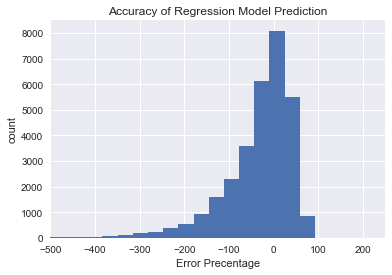

In [43]:
x = plt.hist(test.diff_ratio, bins = 100)
plt.xlim(-500, 250)
plt.xlabel('Error Precentage')
plt.ylabel('count')
plt.title('Accuracy of Regression Model Prediction')

In [44]:
mean_squared_error(test.reach, test.test_reach)**.5

1871.6252599229363

### Things are still a bit off. Let's look at the weirdos. 

We once again explored the data in order to see what the values looked like when they produced a result that was off by more than 200%.  This helped us see that the most important ratios were our variables to reach. When those were violated, our results were massively off. 

In [45]:
wierdos = df2.loc[df2.diff_ratio<-200]

Text(0.5, 1.0, ' Comments Correlation plot')

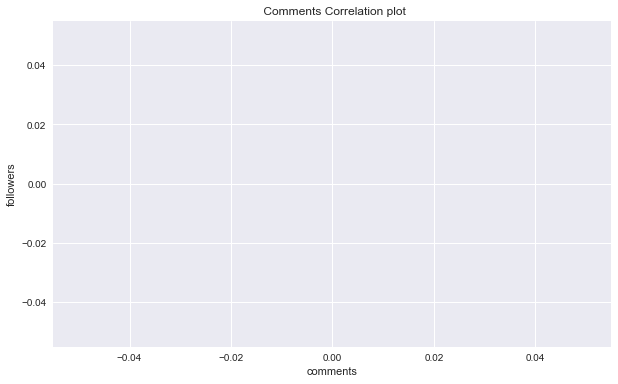

In [46]:
plt.figure(figsize=(10,6))
sns.scatterplot(y=wierdos.followers, x=wierdos.comments, color='red')
plt.xlabel('comments')
plt.ylabel('followers')
plt.title(" Comments Correlation plot")

## Interactions.
Lets create a plot to see if the three variables are interacting with each other in the model. 

In [47]:
from sklearn.linear_model import LinearRegression
regression_1 = LinearRegression()
regression_2 = LinearRegression()
regression_3 = LinearRegression()

likes = df2["likes"].values.reshape(-1, 1)
comments = df2["comments"].values.reshape(-1, 1)
followers = df2["followers"].values.reshape(-1, 1)

regression_1.fit(likes, df2["reach"])
regression_2.fit(comments, df2["reach"])
regression_3.fit(followers, df2["reach"])

# Make predictions using the testing set
pred_1 = regression_1.predict(likes)
pred_2 = regression_2.predict(comments)
pred_3 = regression_3.predict(followers)

# The coefficients
print(regression_1.coef_)
print(regression_2.coef_)
print(regression_3.coef_)

[3.94789543]
[31.57834827]
[0.22570816]


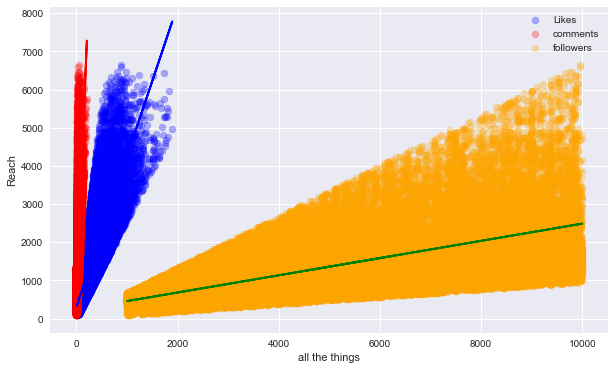

In [48]:
# Plot outputs
plt.figure(figsize=(10,6))

plt.scatter(likes, df2["reach"],  color='blue', alpha = 0.3, label = "Likes")
plt.scatter(comments, df2["reach"],  color='red', alpha = 0.3, label = "comments")
plt.scatter(followers, df2["reach"],  color='orange', alpha = 0.3, label = "followers")

plt.plot(likes, pred_1,  color='blue', linewidth=2)
plt.plot(comments, pred_2,  color='red', linewidth=2)
plt.plot(followers, pred_3,  color='green', linewidth=2)
plt.ylabel("Reach")
plt.xlabel("all the things")
plt.legend();

## Summary of Trial Ratio Method to Determine Outliers

This method has given us the most accurate results, abeit obvious as we have stronghanded the outlier data. We have decided to move forward with this process of removing outliers by ratio to reach. We will keep the cuts symetric and unifrom.